#Support Vector Binary Classification of Disease State with Cycle Averaged Sensor Data
##Input Data: 15 sensor map of the cardiac cycle over a 1 second period ($15\times2000$)

##Investigation of:
* Classifier prediction performance.
* Out of sample prediction error.
* The effect of kernel choice: Linear, Polynomial, RBF.
* The effect of subsampling the time series. From full 2000 down to 10.

**Daniel Wilson and John Mooney**

In [3]:
#Healthy defined as 0
#Unhealthy defined as 1

In [4]:
import mlpy.wavelet
import mcg
import numpy as np
import datetime
import timeit
import time
import copy
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import pandas as pd
import time
import gc
from matplotlib.mlab import PCA
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from sklearn import svm
from sklearn import preprocessing
#matplotlib

mcg.deviceID = 'mk1'
mcg.setDeviceID()

#%matplotlib inline
from skimage.feature import match_template

mk1


# Import training data

In [ ]:
path60  = '/home/john/Dropbox/Mubashir/6060DataFrame.pkl'
df60 = pd.read_pickle(path60)
#Randomly shuffle lst
df60 = df60.iloc[np.random.permutation(len(df60))]

In [ ]:
X = df60['Coil Data'].values.tolist()

#checking to see if there are any floats, caused by the Nans, should still have 120
for i, x in enumerate(X):
    if type(x)==float:
        print x
        index = []
        index.extend([i])

#Cutting the readings down to 2000
for i, x in enumerate(X):
    X[i] = x.T[0:2000].T

#flattening X
for i, x in enumerate(X):
    X[i]= x.flatten()
    

val = preprocessing.scale(X)

# MC optimised SVC

In [ ]:
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV #optimizing gamma and c
from sklearn.grid_search import RandomizedSearchCV #optimizing gamma and c
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import learning_curve
from scipy import interp
import scipy
import random
import sys
from sklearn.learning_curve import learning_curve

# Learning curve

# Compute Learning curves

In [ ]:
subsample_list = [200, 100, 50, 40, 20, 10, 5, 4, 1]
learning_surface = []

for i, every in enumerate(subsample_list):
    print every
    X = val
    subsampled=[]
    for i, x in enumerate(X):
        subsampled.append(x.T[::every].T)
    subsampled = np.asarray(subsampled)
    
    clf, step_list, lc_dict, roc_dict, hyp_dict = learn(subsampled, y, init_range=[1, 0.005], n_folds=5, n_jobs=7)

    learning_surface.append({'sub_level':every, 'clf':clf, 'step_list':step_list, 'learning_curve':lc_dict, 'roc_dict':roc_dict, 'hyp_dict':hyp_dict})
    
np.save('mc_optimised_learning_surface.npy', learning_surface)

## Or load previous example

In [9]:
learning_surface = np.load('mc_optimised_learning_surface.npy')

# Visualise results

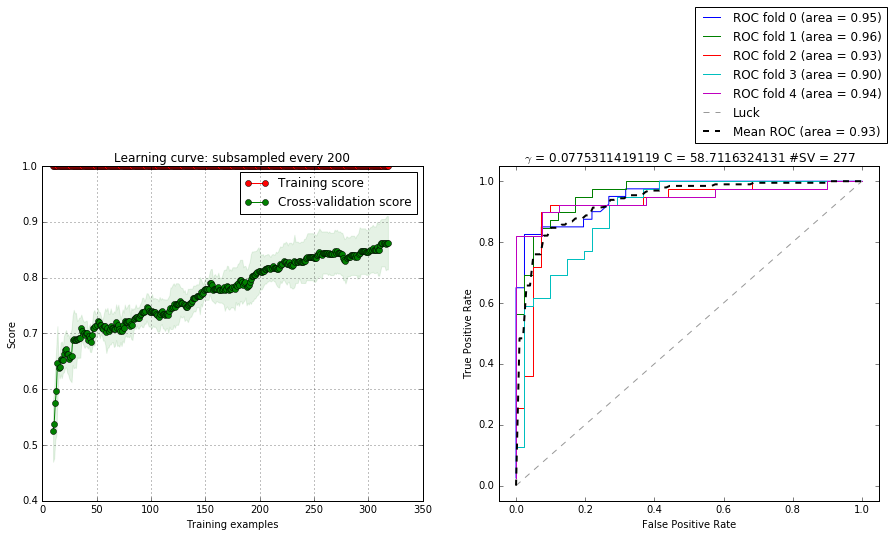

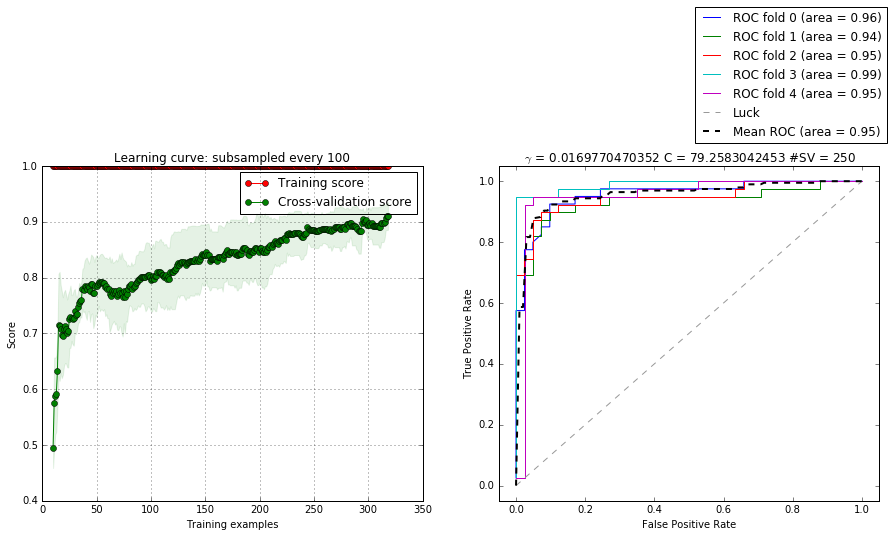

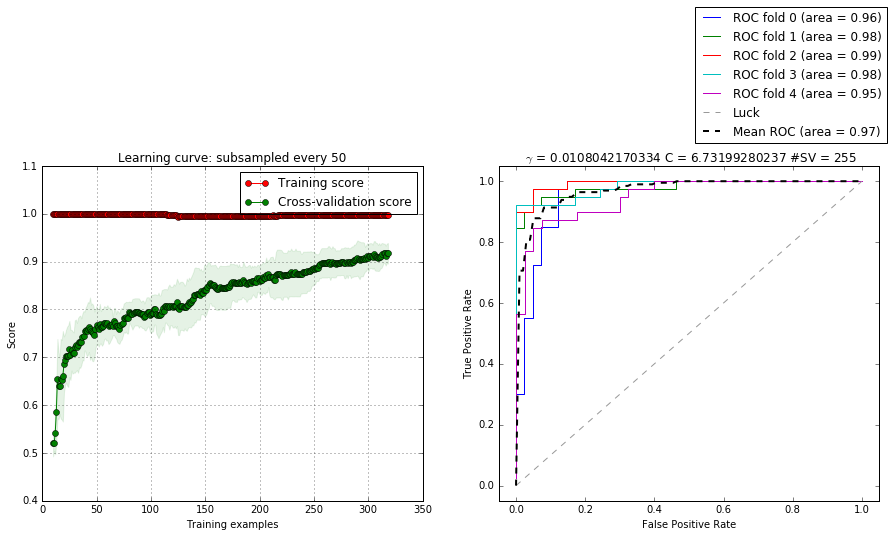

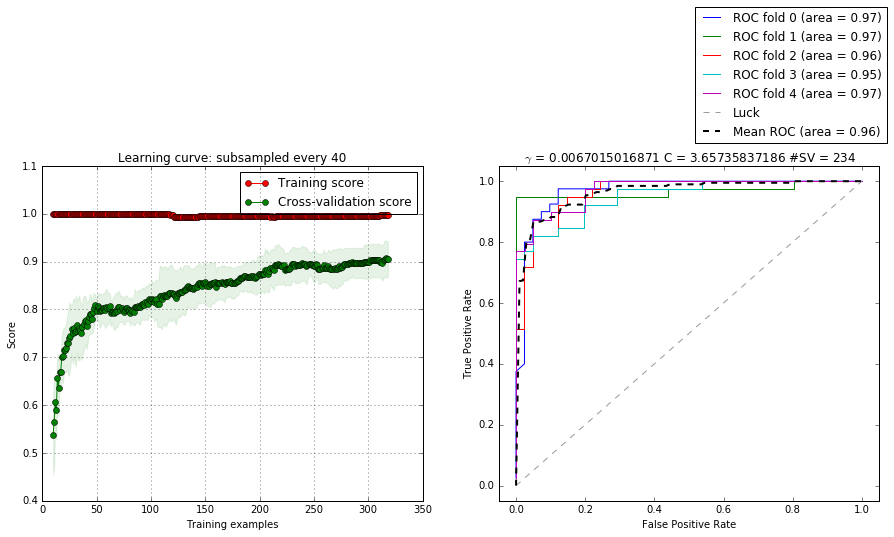

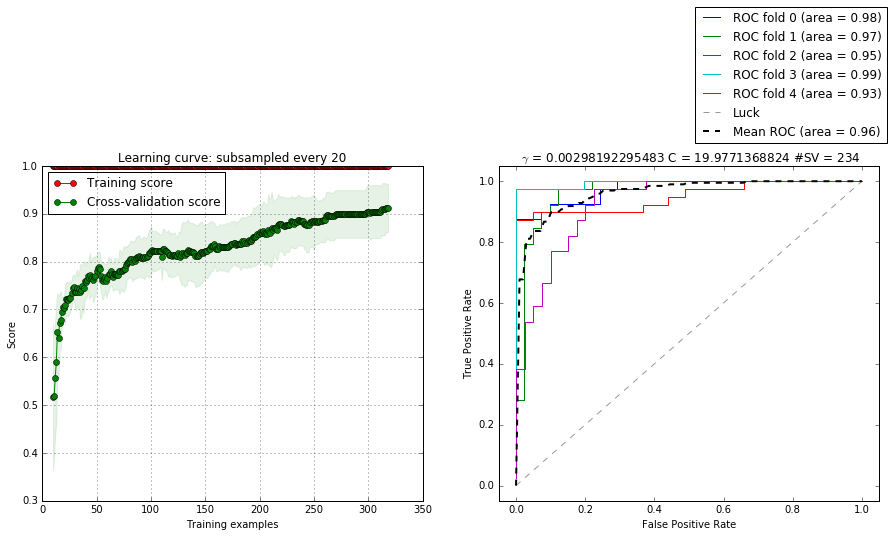

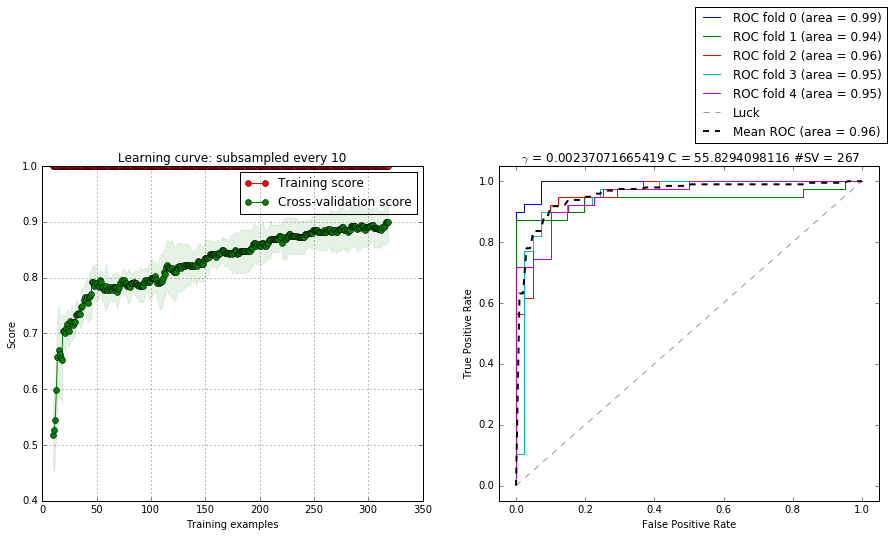

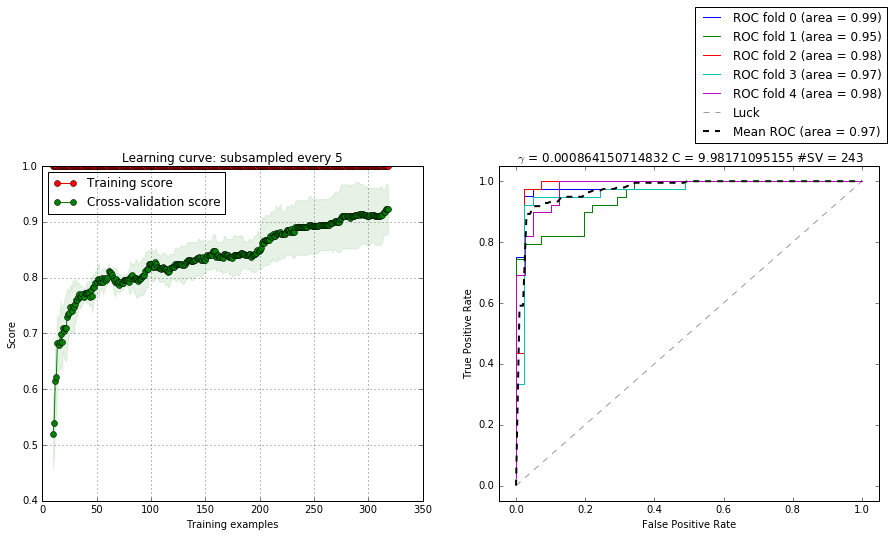

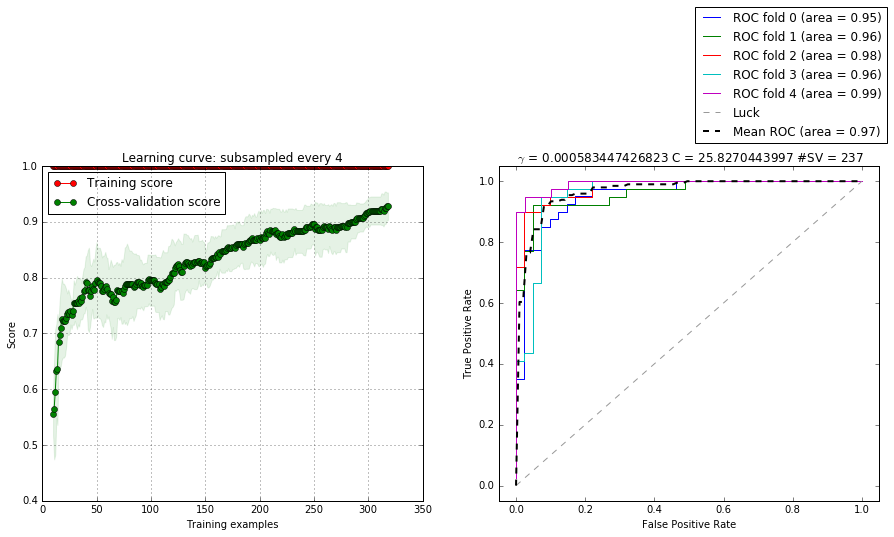

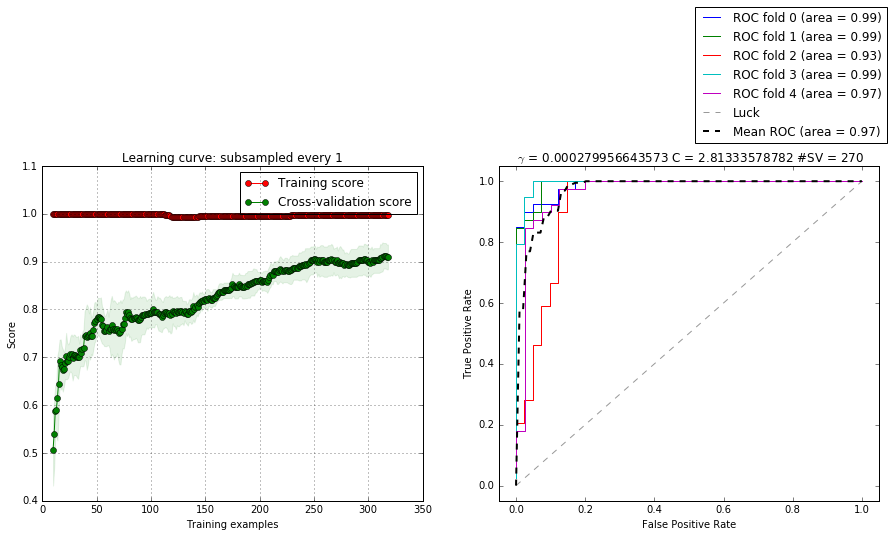

In [40]:
for i, sample in enumerate(learning_surface):
    #print sample
    
    lc_dict = sample['learning_curve']
    roc_dict = sample['roc_dict']
    hyp_dict = sample['hyp_dict']
    plot_learning_curve(lc_dict, roc_dict, hyp_dict, "Learning curve: subsampled every "+str(sample['sub_level']), ylim=None)

9 309
(9, 309)
9 309
(9, 309)


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

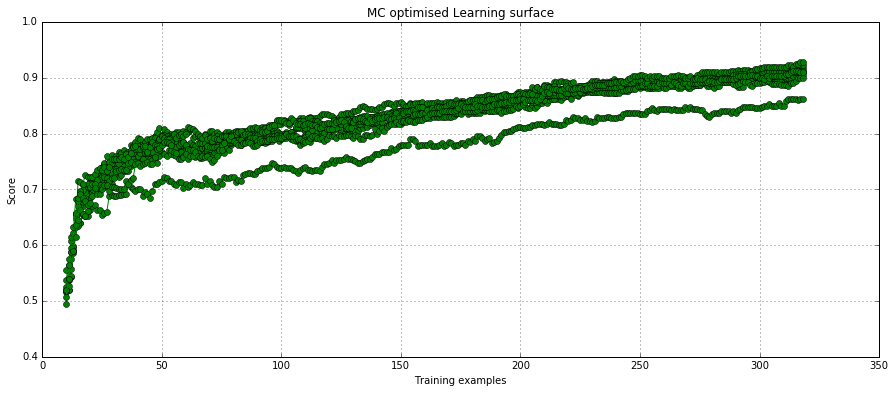

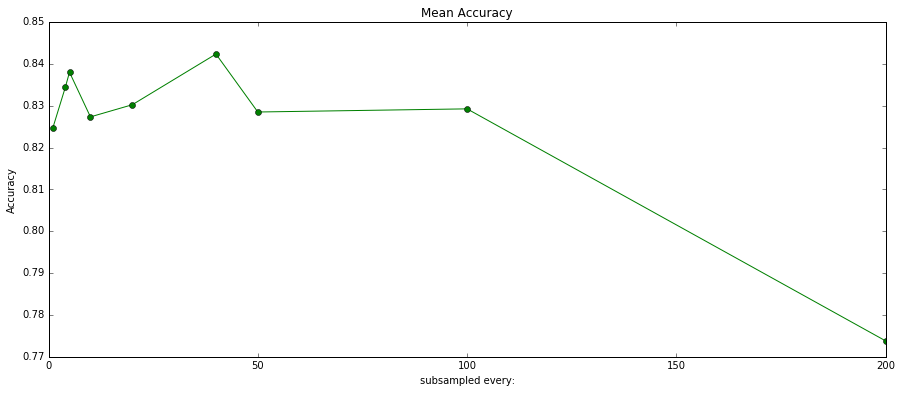

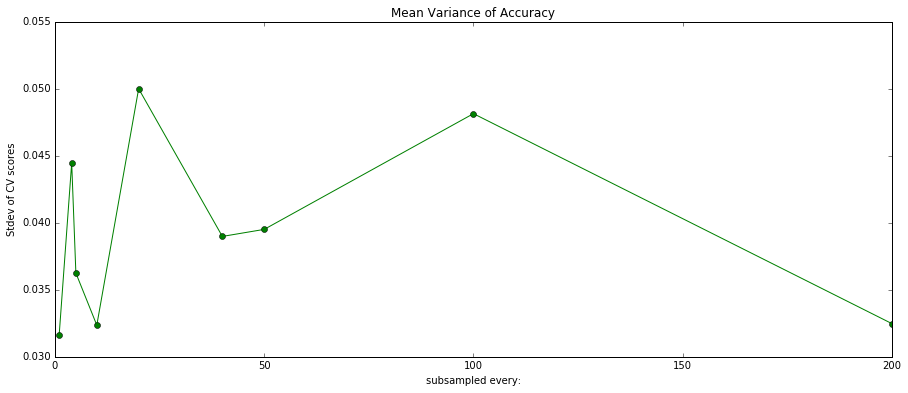

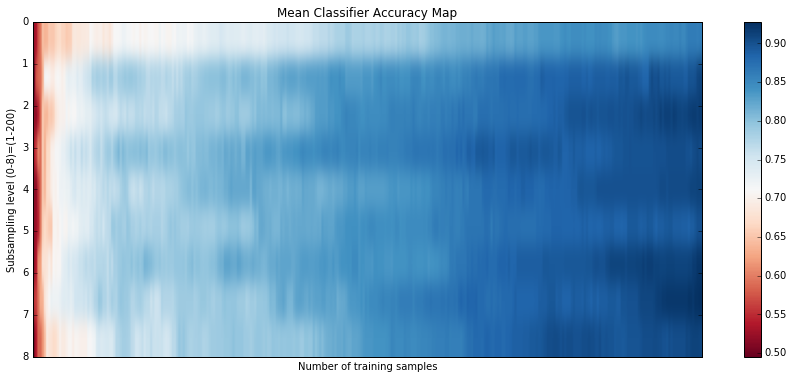

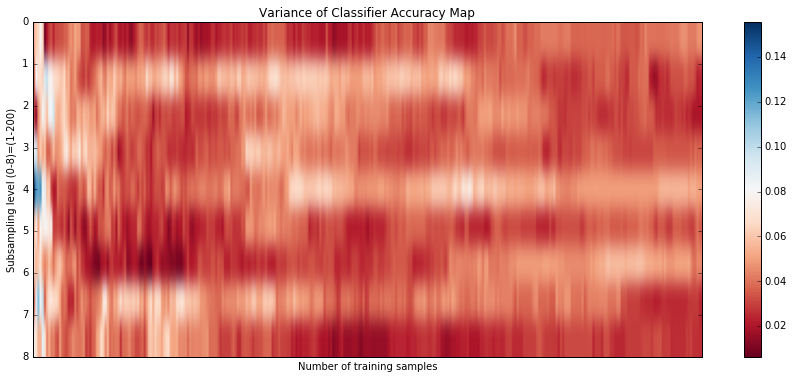

In [73]:
%matplotlib inline
plot_learning_surface(learning_surface, "MC optimised Learning surface")

##Useful Functions

In [6]:
def mcsearch(X, y, clf, CV, beta_min, beta_max, n_iter, epsilon_C, epsilon_gamma,
             epsilon_gamma_min, epsilon_gamma_max,n_jobs=4, init_range=[100,0.05]):
    ##initialise
    n_accepted = 1.0
    step_list=[]
    epsilon_C_min = 0.1
    epsilon_C_max = 10
    epsilon_gamma_min = 1e-7 
    epsilon_gamma_max = 0.01
    fraction_acc_ideal = 0.5
    fraction_acc = 0.0
    
    current = (random.uniform(0.1,init_range[0]), random.uniform(0, init_range[1]))
    clf.C = current[0]
    clf.gamma = current[1]
    fitness_current = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    step_list.append({'step':1, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current, 'frac_acc':1.0})
    #step_list = [{'step':0, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current}]
    #Loop
    for step in range(2, n_iter):
        #beta = beta_min * pow(beta_max/beta_min,(float(step)-1)/(float(n_iter)-1))
        #beta = beta_min + beta_max*(float(step)-1)/(float(n_iter)-1)
        beta = beta_min + beta_max*pow((float(step)-1)/(float(n_iter)-1),2)
        
        scaling_factor = abs(fraction_acc - fraction_acc_ideal)
        if fraction_acc > fraction_acc_ideal:
            epsilon_C = epsilon_C/scaling_factor
            epsilon_gamma = epsilon_gamma/scaling_factor
        else:
            epsilon_C = epsilon_C*scaling_factor
            epsilon_gamma = epsilon_gamma*scaling_factor
        
        if epsilon_gamma < epsilon_gamma_min:
            epsilon_gamma = epsilon_gamma_min
        elif epsilon_gamma > epsilon_gamma_max:
            epsilon_gamma = epsilon_gamma_max
        if epsilon_C < epsilon_C_min:
            epsilon_C = epsilon_C_min
        elif epsilon_C > epsilon_C_max:
            epsilon_C = epsilon_C_max
        
        
        
        proposed = generateMove(current, epsilon_C, epsilon_gamma) 
        clf.C = proposed[0]
        clf.gamma = proposed[1]
        fitness_proposed = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    
        #cost
        relative_fitness = fitness_proposed - fitness_current
        if relative_fitness < 0:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        elif np.log(random.random()) <= -1* beta * relative_fitness:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        
        
        fraction_acc = float(n_accepted)/float(step)
        if step <= 2:
            fraction_acc = 1
            
        print "n_acc, step, frac_acc ", n_accepted, step, fraction_acc
        
        

        
        step_stats = {'step':step, 'C':current[0], 'gamma':current[1], 
                          'fitness':fitness_current, 'frac_acc':fraction_acc, 
                          'epsilon_C':epsilon_C, 'epsilon_gamma':epsilon_gamma,
                         'beta':beta}
        step_list.append(step_stats)
        print step_stats
     
    return current, fitness_current, step_list
    

def generateMove(current, epsilon_C, epsilon_gamma):
    C = abs(random.gauss(current[0], epsilon_C))
    gamma = abs(random.gauss(current[1], epsilon_gamma))
    return (C, gamma)


def optimize_hyp(X, y, clf, CV, init_range=[1, 0.005], n_jobs=4):
    
    current, current_fitness, step_list = mcsearch(X, y, clf, CV, beta_min=1, beta_max=2*pow(10,3),
                                                   n_iter=150, epsilon_C=2, epsilon_gamma=0.001,
                                                   epsilon_gamma_min=1e-7, epsilon_gamma_max=0.01,
                                                   n_jobs=n_jobs, init_range=init_range)
    C = current[0]
    gamma = current[1]
    round1_fitness = current_fitness
    
    current, current_fitness, step_list = mcsearch(X, y, clf, CV, beta_min=1, beta_max=pow(10,4),
                                                   n_iter=100, epsilon_C=5, epsilon_gamma=gamma*0.5,
                                                   epsilon_gamma_min=1e-7, epsilon_gamma_max=gamma*2,
                                                   n_jobs=n_jobs, init_range=[1,gamma])
    if round1_fitness < current_fitness:
        C = current[0]
        gamma = current[1]

    clf.C = C
    clf.gamma = gamma
    accuracy, err, mean_sen, mean_spec, sen_list, spec_list, SV = evaluate_gridsearch(X, y, clf, CV, n_jobs=n_jobs)
    
    hyp_dict = {'accuracy':accuracy, 'err':err, 'mean_sen':mean_sen, 'mean_spec':mean_spec, 
                'sen_list':sen_list, 'spec_list':spec_list, 'SV':SV, 'C':C, 'gamma':gamma,
               'c_range':c_range, 'gamma_range':gamma_range}
    
    return clf, step_list, hyp_dict


def learn(X, y, init_range, n_folds=5, n_jobs=1):
    ##initialise
    clf = svm.SVC(kernel="rbf", probability = True, cache_size = 3000, class_weight = 'balanced')
    CV = cross_validation.StratifiedKFold(y, n_folds=5, shuffle = True)
    
    ##Optimise hyperparameters
    clf, step_list, hyp_dict = optimize_hyp(X, y, clf, CV, init_range=init_range, n_jobs=n_jobs)
    print "optimised params"
    ##ROC curve
    pr_lst, mean_tpr, mean_fpr, mean_auc = ROC_data(X, y, clf, CV)
    roc_dict = {'pr_lst':pr_lst, 'mean_tpr':mean_tpr, 'mean_fpr':mean_fpr, 'mean_auc':mean_auc}
    
    ##Train sizes
    upper = (len(y)-(len(y)/n_folds)-1)
    print upper
    train_sizes=range(10, upper)
    
    ##Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, n_jobs=n_jobs, 
                                                            cv=CV, train_sizes=train_sizes)
    lc_dict = {'train_sizes':train_sizes, 'train_scores':train_scores, 'test_scores':test_scores}
    
    return clf,  step_list, lc_dict, roc_dict, hyp_dict

In [72]:
def ROC_plot(ax, pr_lst,mean_tpr,mean_fpr,mean_auc,C,gamma,SV):
    for i, (fpr,tpr,roc_auc) in enumerate(pr_lst):
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    ax.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(" $\gamma$ = " + str(gamma) + " C = " + str(C) + " #SV = " + str(sum(SV)))
    ax.legend(loc='best', bbox_to_anchor=(0.5, 1.05))
    
    return ax


def plot_learning_curve(lc_dict, roc_dict, hyp_dict, title, ylim=None):
    train_sizes = lc_dict['train_sizes']
    train_scores = lc_dict['train_scores']
    test_scores = lc_dict['test_scores']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=500)
    ax1.set_title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    ax1.set_xlabel("Training examples")
    ax1.set_ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.grid()

    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax1.legend(loc="best")
    #plot ROC
    C = hyp_dict['C']
    gamma = hyp_dict['gamma']
    SV = hyp_dict['SV']
    pr_lst = roc_dict['pr_lst']
    mean_tpr = roc_dict['mean_tpr']
    mean_fpr = roc_dict['mean_fpr']
    mean_auc = roc_dict['mean_auc']
    ax2 = ROC_plot(ax2, pr_lst,mean_tpr,mean_fpr,mean_auc,C,gamma,SV)
    
    
    plt.savefig(title, dpi=500)
    return plt

def plot_learning_surface(learning_surface, title):

    fig=plt.figure(figsize=(15, 6), dpi=100)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=500)
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    steplist = []
    for i, sample in enumerate(learning_surface):
        lc_dict = sample['learning_curve']
        train_sizes = lc_dict['train_sizes']
        test_scores = lc_dict['test_scores']
        test_scores_mean = np.mean(test_scores, axis=1)
        steplist.append(sample['sub_level'])
    
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    meanscore = []
    varscore=[]
    for i, sample in enumerate(learning_surface):
        lc_dict = sample['learning_curve']
        train_sizes = lc_dict['train_sizes']
        test_scores = lc_dict['test_scores']
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        meanscore.append(test_scores_mean)
        varscore.append(test_scores_std)
    title = "Mean Accuracy"
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("subsampled every:")
    plt.plot(steplist, np.mean(meanscore, axis=1), 'o-', color="g",
                label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    plt.title("Mean Variance of Accuracy")
    plt.ylabel("Stdev of CV scores")
    plt.xlabel("subsampled every:")
    plt.plot(steplist, np.mean(varscore, axis=1), 'o-', color="g",
                label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    title = "Mean Classifier Accuracy Map"
    plt.title(title)
    plt.ylabel("Subsampling level (0-8)=(1-200)")
    plt.xlabel("Number of training samples")
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks([])
    data = np.array(meanscore)
    length = data.shape[0]
    width = data.shape[1]
    print length, width
    print data.shape
    x, y = np.meshgrid(np.arange(length), np.arange(width))
    #ax.plot_surface(x, y, data)
    im = ax.imshow(data, cmap=matplotlib.cm.RdBu, vmin=abs(data).min(), vmax=abs(data).max(), extent=[0, 16, 8, 0])
    im.set_interpolation('kaiser')
    cb = fig.colorbar(im, ax=ax)
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    title = "Variance of Classifier Accuracy Map"
    plt.title(title)
    plt.ylabel("Subsampling level (0-8)=(1-200)")
    plt.xlabel("Number of training samples")
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks([])
    vardata = np.array(varscore)
    length = vardata.shape[0]
    width = vardata.shape[1]
    print length, width
    print vardata.shape
    x, y = np.meshgrid(np.arange(length), np.arange(width))
    #ax.plot_surface(x, y, data)
    im = ax.imshow(vardata, cmap=matplotlib.cm.RdBu, vmin=abs(vardata).min(), vmax=abs(vardata).max(), extent=[0, 16, 8, 0])
    im.set_interpolation('kaiser')
    cb = fig.colorbar(im, ax=ax)
    plt.savefig(title, dpi=500)
    
    return plt

In [3]:
def plot_gridsearch(grid, c_range, gamma_range, vmin=None, midpoint=None):
    scores = [x[1] for x in grid.grid_scores_]
    min_score = min(scores)
    scores = np.array(scores).reshape(len(c_range), len(gamma_range))

    #np.save('gridsearchscores_full.npy', scores)

    class MidpointNormalize(Normalize):

        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))

    if midpoint is None:
        midpoint = min_score + ((grid.best_score_-min_score) /2)

    if vmin is None:
        vmin = min_score
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=vmin, midpoint=midpoint))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
    plt.yticks(np.arange(len(c_range)), c_range)
    plt.title('Validation accuracy')
    plt.show()



def evaluate_gridsearch(X, y, clf, CV, n_jobs=4):
    #nested cross validation score
    CVS = cross_validation.cross_val_score
    scores = CVS(clf, X, y, cv=CV, n_jobs = n_jobs)
    print scores
    
    accuracy = scores.mean()
    err = scores.std() * 2
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy, err))
    #this tells us how well its actualy performing, due to the unbalanced data

    
    sen_list = []
    spec_list = []


    for i, (train, test) in enumerate(CV):
        #print "train", train
        #print "test", test
        y_pred = clf.fit(X[train], y[train]).predict(X[test])
        #print y_pred,"predicted"
        #print y[test], "actual"
        cm = confusion_matrix(y[test], y_pred)

        tn = float(cm[0][0])/np.sum(cm[0])
        tp = float(cm[1][1])/np.sum(cm[1])
        print "sensitivity: ", tn, "spec: ", tp
        sen_list.append(tn)
        spec_list.append(tp)

    mean_sen = sum(sen_list)/float(len(sen_list))
    mean_spec = sum(spec_list)/float(len(sen_list))
    print "Mean sensitivity is", mean_sen
    print "Mean specificity is", mean_spec

    SV = clf.n_support_
    print sum(SV),SV
    
    return accuracy, err, mean_sen, mean_spec, sen_list, spec_list, SV


def ROC_data(X, y, clf, cv):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr =[]
    pr_lst = []
    
    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr) 
        pr_lst.append([fpr, tpr, roc_auc])
        
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    
    return pr_lst, mean_tpr, mean_fpr, mean_auc

In [213]:
%time clf, grid, hyp_dict = optimize_hyp(subsampled, y, clf, CV, init_range=[20, 0.05], n_jobs=8)

CPU times: user 2.26 s, sys: 800 ms, total: 3.06 s
Wall time: 19.4 s
C, gamma: 4.82991075383 0.0263584371684
CPU times: user 1.99 s, sys: 1.08 s, total: 3.08 s
Wall time: 13.3 s
C, gamma: 3.86392860306 0.0269441802166
0.91
{'C': 3.8639286030611704, 'gamma': 0.026944180216637727}
[ 0.9382716   0.95        0.975       0.8875      0.79746835]
Accuracy: 0.91 (+/- 0.13)
sensitivity:  0.975609756098 spec:  0.9
sensitivity:  1.0 spec:  0.897435897436
sensitivity:  1.0 spec:  0.948717948718
sensitivity:  0.878048780488 spec:  0.897435897436
sensitivity:  1.0 spec:  0.589743589744
Mean sensitivity is 0.970731707317
Mean specificity is 0.846666666667
265 [144 121]
CPU times: user 5.69 s, sys: 1.89 s, total: 7.57 s
Wall time: 34.2 s


In [288]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, ylim=None):
    plt.figure(dpi=500)
    plt.title(title)
    ax=plt.subplot?
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    #print train_sizes
    plt.savefig(title, dpi=500)
    return plt

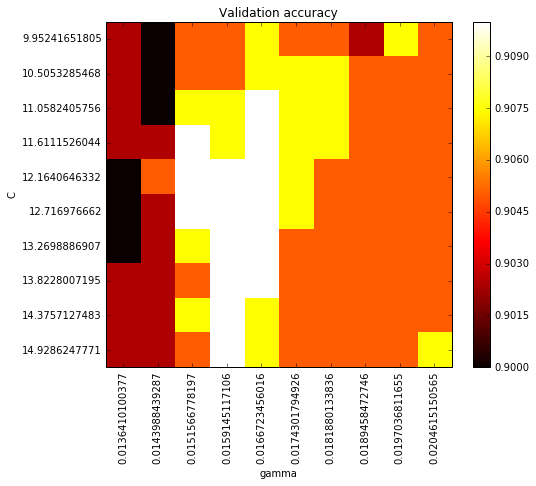

In [212]:
plot_gridsearch(grid, hyp_dict['c_range'], hyp_dict['gamma_range'])#, vmin=0.2, midpoint=0.81)

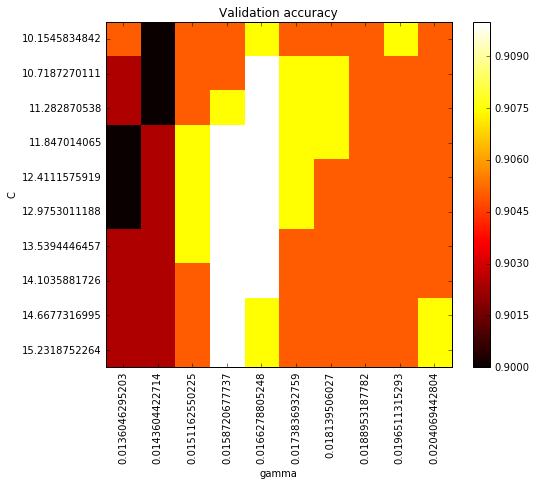

In [204]:
plot_gridsearch(grid, hyp_dict['c_range'], hyp_dict['gamma_range'])#, vmin=0.2, midpoint=0.81)

In [231]:
def learn(X, y, init_range, n_folds=5, n_jobs=1):
    ##initialise
    clf = svm.SVC(kernel="rbf", probability = True, cache_size = 3000, class_weight = 'balanced')
    CV = cross_validation.StratifiedKFold(y, n_folds=5, shuffle = True)
    
    ##Optimise hyperparameters
    clf, step_list, hyp_dict = optimize_hyp(X, y, clf, CV, init_range=init_range, n_jobs=n_jobs)
    print "optimised params"
    ##ROC curve
    pr_lst, mean_tpr, mean_fpr, mean_auc = ROC_data(X, y, clf, CV)
    roc_dict = {'pr_lst':pr_lst, 'mean_tpr':mean_tpr, 'mean_fpr':mean_fpr, 'mean_auc':mean_auc}
    
    ##Train sizes
    upper = (len(y)-(len(y)/n_folds)-1)
    print upper
    train_sizes=range(10, upper)
    
    ##Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, n_jobs=n_jobs, 
                                                            cv=CV, train_sizes=train_sizes)
    lc_dict = {'train_sizes':train_sizes, 'train_scores':train_scores, 'test_scores':test_scores}
    
    return clf,  grid, lc_dict, roc_dict, hyp_dict

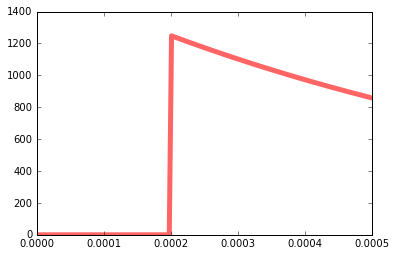

In [260]:
fig, ax = plt.subplots(1, 1)

#x = np.linspace(scipy.stats.expon.ppf(0),
#                scipy.stats.expon.ppf(0.05), 150)
x = np.linspace(0,0.0005, 150)

ax.plot(x, scipy.stats.expon.pdf(x, loc=0.0002, scale=0.0008),
       'r-', lw=5, alpha=0.6, label='expon pdf')

#ax.plot(x, 50*scipy.stats.expon.pdf(x, scale=0.05),
#       'r-', lw=5, alpha=0.6, label='expon pdf')

In [232]:
#train_sizes=range(10,310)
subsample_list = [1, 2, 4, 5, 10, 20, 40, 50, 100, 200]
#subsample_list = [100, 200]
learning_surface = []

for i, every in enumerate(subsample_list):
    print every
    X = val
    subsampled=[]
    for i, x in enumerate(X):
        subsampled.append(x.T[::every].T)
    subsampled = np.asarray(subsampled)
    
    clf, grid, lc_dict, roc_dict, hyp_dict = learn(subsampled, y, init_range=[20, 0.0008], n_folds=5, n_jobs=7)

    learning_surface.append({'sub_level':every, 'clf':clf, 'grid':grid, 'learning_curve':lc_dict, 'roc_dict':roc_dict, 'hyp_dict':hyp_dict})
    
np.save('optimised_learning_surface.npy', learning_surface)

1
CPU times: user 2min 37s, sys: 3.41 s, total: 2min 40s
Wall time: 2h 3min 4s
C, gamma: 5.55187757477 0.00156075259856
CPU times: user 2min 4s, sys: 3.69 s, total: 2min 8s
Wall time: 1h 55min 22s
C, gamma: 4.44150205982 0.00124860207885
0.81
{'C': 4.4415020598179424, 'gamma': 0.0012486020788511905}
[ 0.82716049  0.7875      0.7875      0.775       0.87341772]
Accuracy: 0.81 (+/- 0.07)
sensitivity:  1.0 spec:  0.65
sensitivity:  1.0 spec:  0.564102564103
sensitivity:  1.0 spec:  0.564102564103
sensitivity:  0.975609756098 spec:  0.564102564103
sensitivity:  0.975 spec:  0.769230769231
Mean sensitivity is 0.99012195122
Mean specificity is 0.622307692308
301 [156 145]
optimised params
319
2
CPU times: user 1min 25s, sys: 2.62 s, total: 1min 28s
Wall time: 1h 25min 49s
C, gamma: 17.4228158345 0.000396419379679
CPU times: user 1min 2s, sys: 1.96 s, total: 1min 4s
Wall time: 54min 45s
C, gamma: 13.9382526676 0.000369991421034
0.9275
{'C': 13.93825266759767, 'gamma': 0.00036999142103379834}


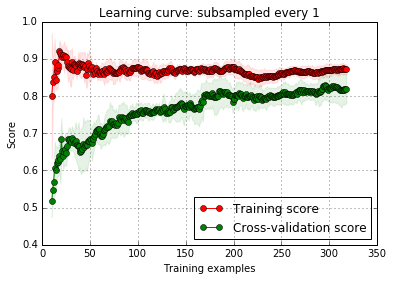

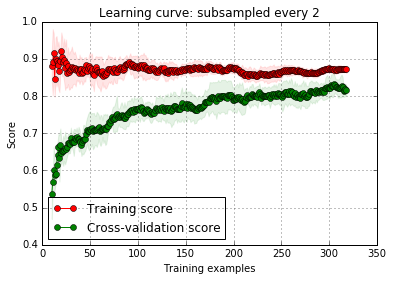

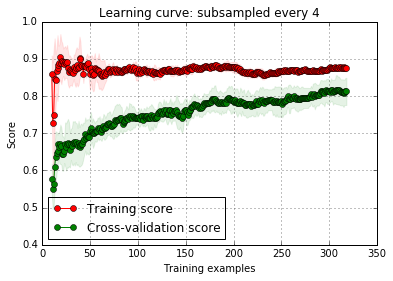

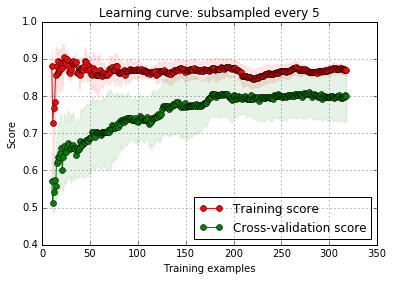

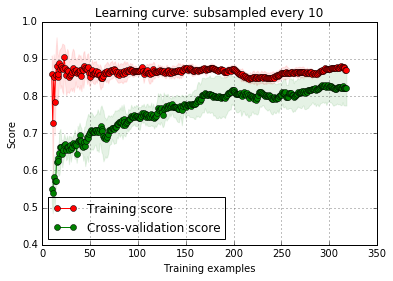

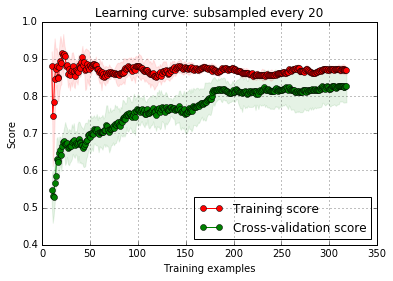

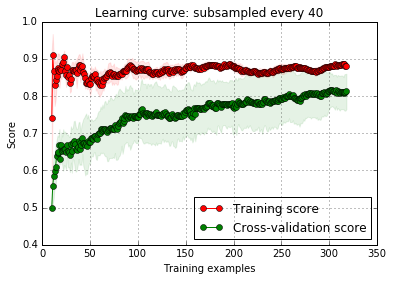

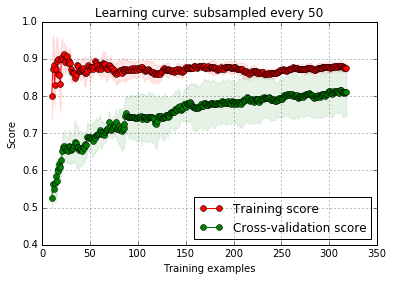

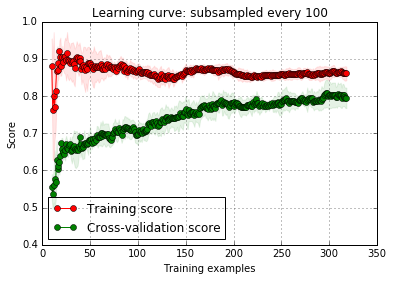

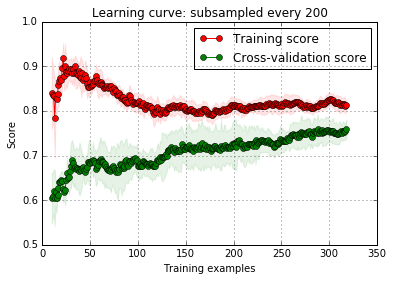

In [233]:
for i, sample in enumerate(learning_surface):
    #print sample
    lc_dict = sample['learning_curve']
    plot_learning_curve(lc_dict['train_sizes'], lc_dict['train_scores'], lc_dict['test_scores'], 
                        "Learning curve: subsampled every "+str(sample['sub_level']), ylim=None)


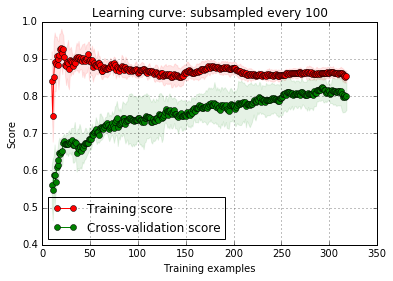

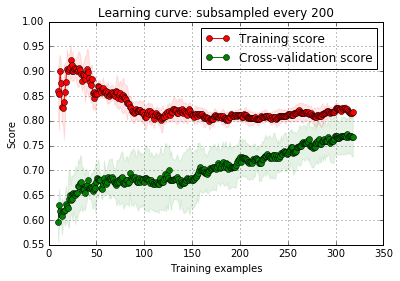

In [230]:
for i, sample in enumerate(learning_surface):
    #print sample
    lc_dict = sample['learning_curve']
    plot_learning_curve(lc_dict['train_sizes'], lc_dict['train_scores'], lc_dict['test_scores'], 
                        "Learning curve: subsampled every "+str(sample['sub_level']), ylim=None)


In [108]:
np.save('unoptimised_learning_surface.npy', learning_surface)

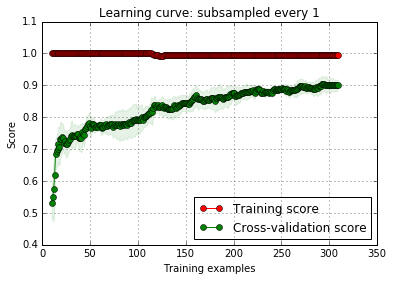

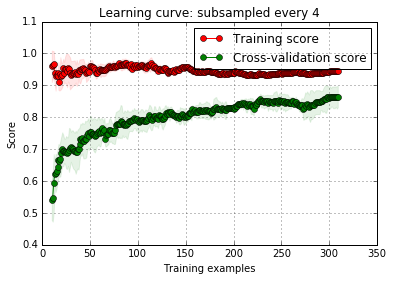

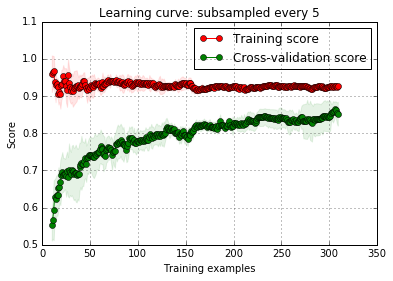

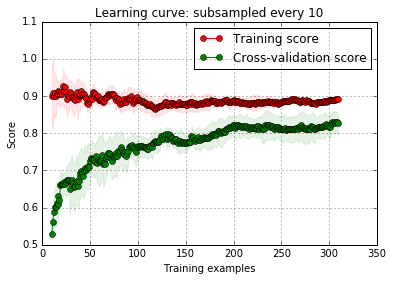

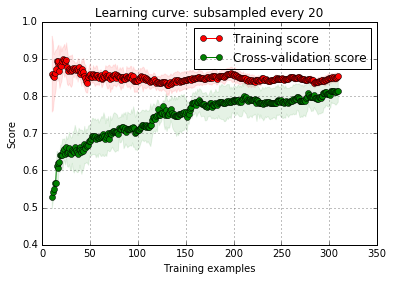

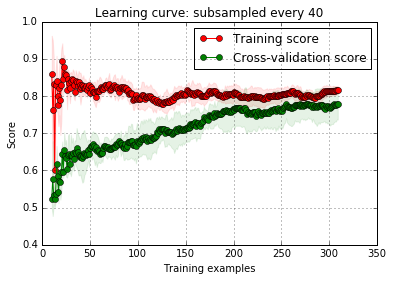

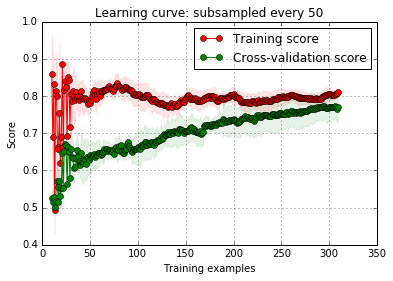

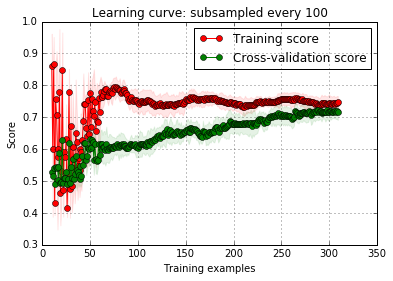

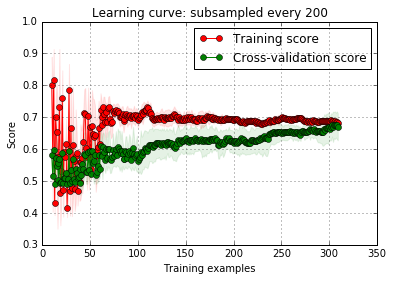

In [107]:
for i, sample in enumerate(learning_surface):
    #print sample
    lcdata = sample['learning_curve']
    plot_learning_curve(lcdata[0], lcdata[1], lcdata[2], "Learning curve: subsampled every "+str(sample['sub_level']), ylim=None)

    
    
    
    
#plot_learning_curve(lcdata[0], lcdata[1], lcdata[2], "Learning curve", ylim=None)

In [94]:
import sys
sys.stdout.flush()

## Combined learn curve and plot

In [98]:
len(y)

311

In [287]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=CV,
                        n_jobs=1, train_sizes=range(65,100)):

    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, n_jobs=n_jobs, cv=CV, train_sizes=train_sizes, verbose=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    print train_sizes
    return plt

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] actual
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] actual
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] actual
[learning_curve] Training set sizes: [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 91 92 93 94 95 96 97 98 99]
[CV] no parameters to be set .........................................


ValueError: The number of classes has to be greater than one; got 1

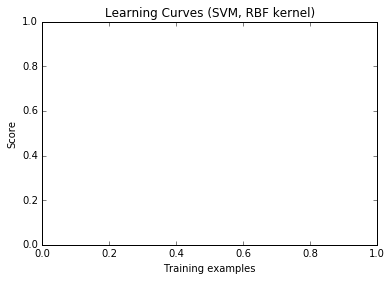

In [84]:
from sklearn import cross_validation
#CV = cross_validation.ShuffleSplit(len(y), n_iter=20,
#                                   test_size=0.1, random_state=0)
CV = cross_validation.StratifiedKFold(y, n_folds=3, shuffle = True)

from sklearn.learning_curve import learning_curve
for i, (train, test) in enumerate(CV):
    y_pred = clf.fit(val[train], y[train]).predict(val[test])
    print y[test], "actual"

#range(65,80)



title = "Learning Curves (SVM, RBF kernel)"

plot_learning_curve(clf, title, val, y, cv = CV, n_jobs=1)

plt.show()

In [108]:
print y

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [151]:


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(y[names]))
    plt.xticks(tick_marks, y[names], rotation=45)
    plt.yticks(tick_marks, y_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.fit(val[train], y[train]).predict(val[test])
    
# Compute confusion matrix
cm = confusion_matrix(y[test], y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[10  0]
 [ 2  0]]


NameError: global name 'names' is not defined

In later work it will be interesting to reduce the dimensionality of the input. In theory this will reduce the classifiers out of sample prediction error (i.e. predicting on data not in the training set).  

This can be done by feature extraction. Resulting in a timeseries of dipole properties (Angle, Length, MinMaxRatio, Dipole Center position and a measure of each peaks circular symmetry (perhaps using a 2D correlation with an idealised dipole of equivalent angle and length) or with an angluar variance measure?) 

In [29]:
digits = load_digits()
X, y = digits.data, digits.target

In [ ]:
y